In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The SamPredictor class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the set_image method, which calculates the necessary image embeddings. Then, prompts can be provided via the predict method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

### Environment Set-up

If running locally using jupyter, first install segment_anything in anaconda in a new environment using the installation (https://anaconda.org/conda-forge/segment-anything) instructions. If running from Google Colab, set using_colab=True below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:
# Necessary imports and helper functions for displaying points, boxes, and masks.

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
else:

    from segment_anything import sam_model_registry, SamPredictor
    import torch
    import torchvision
    from matplotlib.widgets import Button
    import numpy as np
    import torch
    from scipy import ndimage
    import matplotlib.pyplot as plt
    %matplotlib
    %matplotlib

Using matplotlib backend: <object object at 0x000001CF608C6F10>
Using matplotlib backend: TkAgg


In [3]:
def show_mask(mask, ax, random_color=True):
    """
    Displays a binary mask on the given matplotlib axis.

    Args:
        mask (numpy.ndarray): A 2D numpy array representing the binary mask to be displayed.
        ax (matplotlib.axis.Axis): The axis object in which to display the mask.
        random_color (bool, optional): If True, the function will generate a random color for the mask. 
                                       Defaults to False.

    Returns:
        None
    """
    if random_color:
        # If random_color is True, assign a random color of the form (r,g,b,a) to 'color'.
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # Otherwise, use a default shade of blue for the mask.
        color = np.array([30/255, 144/255, 255/255, 0.6])

    # Get the height and width of the mask.
    h, w = mask.shape[-2:]

    # Reshape the mask into an RGB image with the given color.
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    

    # Display the resulting image on the given axis.
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    """
    Displays points on a scatter plot with different colors based on their associated labels.

    Args:
        coords (numpy.ndarray): A 2D numpy array of shape (N,2) containing the coordinates of the points.
        labels (numpy.ndarray): A 1D numpy array of shape (N,) containing the labels (0 or 1) of each point.
        ax (matplotlib.axis.Axis): The axis object in which to display the scatter plot.
        marker_size (int, optional): The size of the markers in the scatter plot. Defaults to 375.

    Returns:
        None
    """
    # Partition the points into those with label 1 and those with label 0.
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]

    # Display the positive points (with label 1) as green stars on the scatter plot.
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    # Display the negative points (with label 0) as red stars on the scatter plot.
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_points_multi_class(coords, labels,ax,marker=10):
    
    # Define a list of colors to use for different classes
    colors = ['red', 'green', 'blue', 'cyan', 'yellow', 'pink', 'lime', 'orange', 'brown']
    
    n_class=np.unique(labels).shape[0]

    for i in range(n_class):
        
        new_cords=coords[labels==i+1]
        
        ax.scatter(new_cords[:,0],new_cords[:,1],color=colors[i],s=marker)
    


### Example image

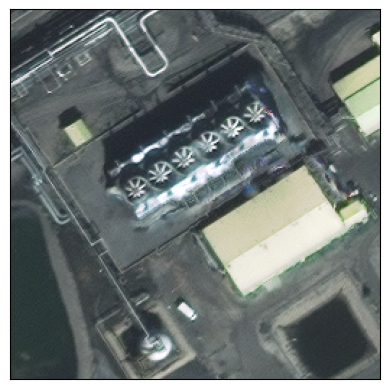

In [5]:
%matplotlib inline
%matplotlib inline
# Define the path to the input image file.
image_path = 'E:/Deep Course/Weeks/W12/Data/2.tif'

# Read in the image from the specified file.
image = plt.imread(image_path)
# image = ndimage.median_filter(image, size=10)
# Display the image using matplotlib's imshow function.
plt.imshow(image)
# Suppress the x and y axis labels (ticks) in the plot.
plt.xticks([])
plt.yticks([])

# Show the plot with the image.
plt.show()

### Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [6]:
if using_colab:
    # Load pre-trained model checkpoint for Vision Transformer model from a web address
    sam_checkpoint = "sam_vit_h_4b8939.pth" # In case you are not utilizing Google Colab, it is recommended that you obtain the SAM checkpoints from this web address: 
                                            #https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    
    # Specify the type of Vision Transformer model to use
    model_type = "vit_h"

    # Initialize segmentation model using a factory function with the loaded checkpoint as an argument
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

    # Create predictor object for the segmentation model
    predictor = SamPredictor(sam)
    
else:
    # Load pre-trained model checkpoint for Vision Transformer model from a web address
    sam_checkpoint = "sam_vit_h_4b8939.pth" # In case you are not utilizing Google Colab, it is recommended that you obtain the SAM checkpoints from this web address: 
                                            #https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

    # Specify the type of Vision Transformer model to use
    model_type = "vit_h"

    # Specify the device to use for computation (CPU or GPU)
    device = "cpu" # If you have gpu on your computer and is campatibale with torch you cand change "cpu" to "cuda".
                    # In order to check torch is compatible with torch in your system you can use torch.cuda.is_available().
                    # If it returns True, you can use cuda.

    # Initialize segmentation model using a factory function with the loaded checkpoint as an argument
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    # Move the segmentation model to the specified device
    sam.to(device=device)
    # Create predictor object for the segmentation model
    predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling SamPredictor.set_image. SamPredictor remembers this embedding and will use it for subsequent mask prediction.

In [7]:
predictor.set_image(image)

To choose the object(s), you can indicate one or more points on it. The points need to be in (x,y) format and have labels of either 1 for foreground or 0 for background. You have the option to input multiple points. An interactive plot is available below which allows you to select point(s) on your image. If you need to choose more than one class, you can click on "New class" button and then select points for the new class.
It's important to note that if you want to choose points on the image, you must press and hold the "A" key on your keyboard and then click on the image.

In [63]:
%matplotlib
%matplotlib


# Set the initial value to 1

c = 1
# Define a list of colors to use for different classes
colors = ['red', 'green', 'blue', 'cyan', 'yellow', 'pink', 'lime', 'orange', 'brown']


# Create a subplot
ax = plt.subplot(111)

# Initialize empty lists to store clicked points and their labels
points = []
labels = []

# Define a function to handle mouse clicks on the image
def onclick(event):
    # Check if the key pressed is 'A'
    if event.key == 'A':
        global points
        global labels

        # Extract the x and y coordinates of the click (rounded to nearest integer)
        x = int(round(event.xdata))
        y = int(round(event.ydata))

        # Plot a circle at the clicked point, using the current class color
        ax.plot(x, y, 'o', markersize=4,color=colors[c-1])
        
        
        plt.show()

        # Print the coordinates of the clicked point
        print('Clicked at x = %d, y = %d' % (x, y))

        # Store the coordinates in the 'points' list, along with their label (current class)
        if x>1 and y >1:
            points.append([x, y])
            labels.append(c)

# Define a function when the "New Class" button is clicked
def run_function(event):
    # Increment the current class counter
    global c
    c = c + 1

# Display the image
plt.imshow(image)

plt.xticks([])

plt.yticks([])

# Connect the mouse click event to the 'onclick()' function
cid = plt.gcf().canvas.mpl_connect('button_press_event', onclick)
# Add a button to the plot
button_ax = plt.axes([0.85, 0.05, 0.2, 0.1])
button = Button(button_ax, 'New Class')
button.on_clicked(run_function)
# Show the plot
plt.show()
# Print the list of clicked points and their labelsaA
print('Clicked points:', points)


Using matplotlib backend: TkAgg
Using matplotlib backend: TkAgg
Clicked points: []
Clicked at x = 12, y = 196
Clicked at x = 224, y = 230
Clicked at x = 198, y = 161
Clicked at x = 166, y = 147
Clicked at x = 45, y = 86
Clicked at x = 138, y = 93
Clicked at x = 120, y = 102
Clicked at x = 103, y = 113
Clicked at x = 87, y = 124
Clicked at x = 153, y = 82
Clicked at x = 168, y = 72
Clicked at x = 247, y = 65
Clicked at x = 242, y = 49
Clicked at x = 149, y = 219
Clicked at x = 79, y = 160
Clicked at x = 0, y = 0
Clicked at x = 121, y = 209


### Sample points on image

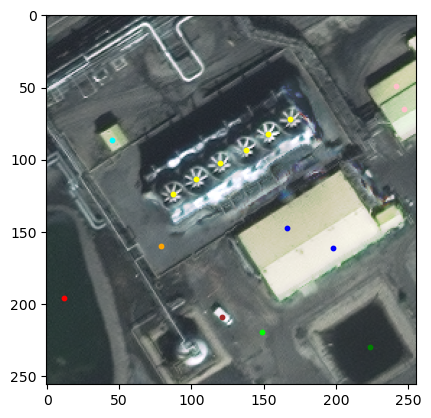

In [64]:
%matplotlib inline
%matplotlib inline
# Convert "points" and "labels" iterables to NumPy arrays
points_np = np.array(points)
labels = np.array(labels)

plt.imshow(image)

show_points_multi_class(points_np, labels,plt.gca(),marker=10)

### Overlay Mask and Image

In [65]:
%matplotlib inline
%matplotlib inline
# Copy NumPy arrays to new variables for convenience
input_point = points_np
input_label = labels

classes=np.unique(labels)
masks_list=[]
scores_list=[]
for c in classes:
    
    new_input_point=input_point[labels==c]
    new_input_label=input_label[labels==c]

    # Call `predict()` method on the `predictor` object
    masks, scores, logits = predictor.predict(
        point_coords=new_input_point,
        point_labels=new_input_label,
        multimask_output=True
    )
    
    masks_list.append(masks)
    scores_list.append(scores)


In [66]:
len(masks_list)

9

In [55]:
masks.shape

(3, 256, 256)

In [56]:
scores

array([0.9954031 , 0.9665872 , 0.71918535], dtype=float32)

In [57]:
logits.shape

(3, 256, 256)

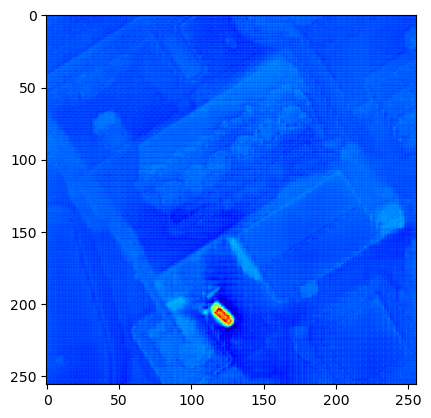

In [67]:
plt.imshow(logits[2,:,:],cmap='jet')

(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)


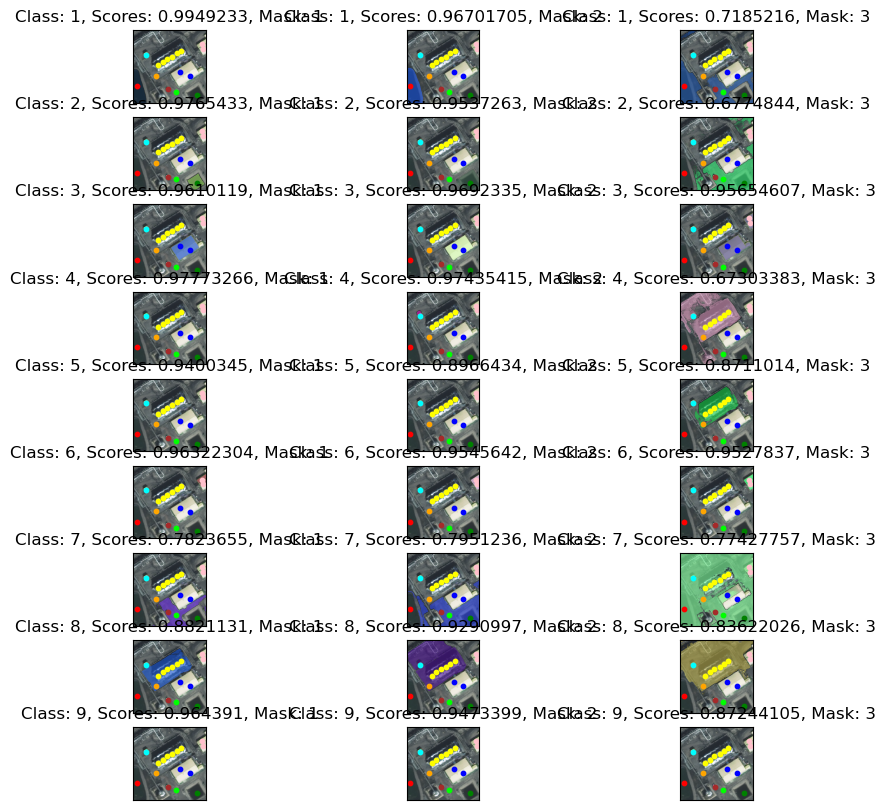

In [68]:
classes=np.unique(labels)
n_class=classes.shape[0]

plt.figure(figsize=(10, 10))

for i in range(n_class):
    
    mask=masks_list[i]
    score=scores_list[i]
    
    plt.subplot(n_class,3,3*i+1)
    # Display original image using `plt.imshow()`
    plt.imshow(image)
    # Show segmentation mask on top of original image using `show_mask()`
    show_mask(mask[0], plt.gca())
    show_points_multi_class(points_np, labels,plt.gca(),marker=10)
    plt.xticks([])
    plt.yticks([])
    plt.title('Class: '+str(i+1)+', Scores: '+str(score[0])+', Mask: '+str(1))
    
    
    plt.subplot(n_class,3,3*i+2)
    # Display original image using `plt.imshow()`
    plt.imshow(image)
    # Show segmentation mask on top of original image using `show_mask()`
    show_mask(mask[1], plt.gca())
    show_points_multi_class(points_np, labels,plt.gca(),marker=10)
    plt.xticks([])
    plt.yticks([])
    plt.title('Class: '+str(i+1)+', Scores: '+str(score[1])+', Mask: '+str(2))
    
    
    plt.subplot(n_class,3,3*i+3)
    # Display original image using `plt.imshow()`
    plt.imshow(image)
    # Show segmentation mask on top of original image using `show_mask()`
    show_mask(mask[2], plt.gca())
    show_points_multi_class(points_np, labels,plt.gca(),marker=10)
    plt.xticks([])
    plt.yticks([])
    plt.title('Class: '+str(i+1)+', Scores: '+str(score[2])+', Mask: '+str(3))
    
plt.show()

### Displaying the masks for each class

Predict with SamPredictor.predict. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

With multimask_output=True (the default setting), SAM outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use multimask_output=True even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

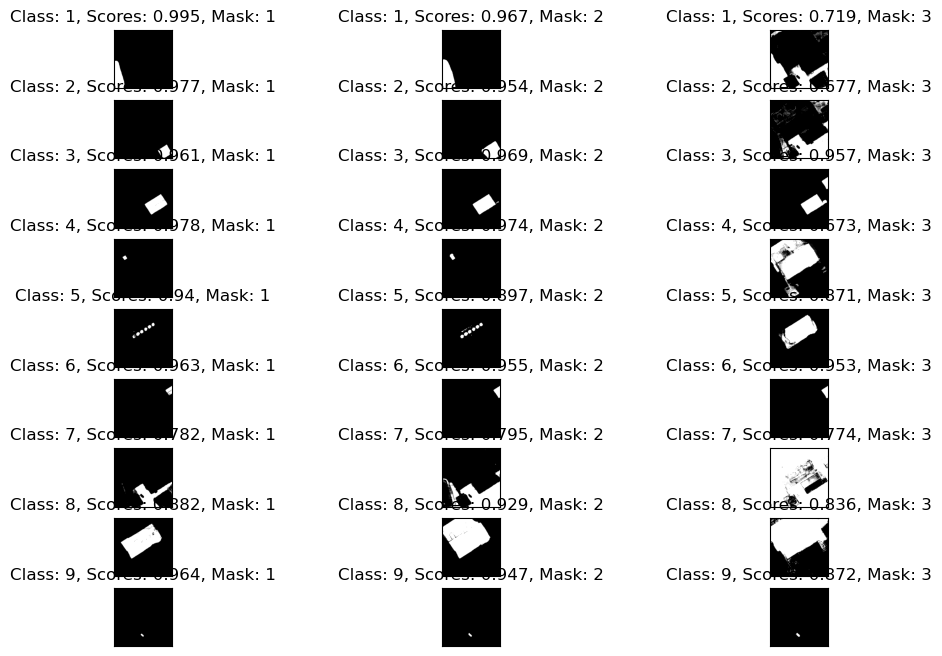

In [69]:


plt.figure(figsize=(12,8),dpi=100)

n_class=classes.shape[0]


for c in range(n_class):
    
    
    mask=masks_list[c]
    score=scores_list[c]
    score=np.round(score,decimals=3)
    
    plt.subplot(n_class,3,3*c+1)
    plt.imshow(mask[0],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Class: '+str(c+1)+', Scores: '+str(score[0])+', Mask: '+str(1))
    
    plt.subplot(n_class,3,3*c+2)
    plt.imshow(mask[1],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Class: '+str(c+1)+', Scores: '+str(score[1])+', Mask: '+str(2))
    
    plt.subplot(n_class,3,3*c+3)
    plt.imshow(mask[2],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Class: '+str(c+1)+', Scores: '+str(score[2])+', Mask: '+str(3))


plt.show()   

# Thematic output Map

Please enter the number corresponding to the best mask for class 1:  1
Please enter the number corresponding to the best mask for class 2:  1
Please enter the number corresponding to the best mask for class 3:  1
Please enter the number corresponding to the best mask for class 4:  1
Please enter the number corresponding to the best mask for class 5:  1
Please enter the number corresponding to the best mask for class 6:  1
Please enter the number corresponding to the best mask for class 7:  2
Please enter the number corresponding to the best mask for class 8:  1
Please enter the number corresponding to the best mask for class 9:  1


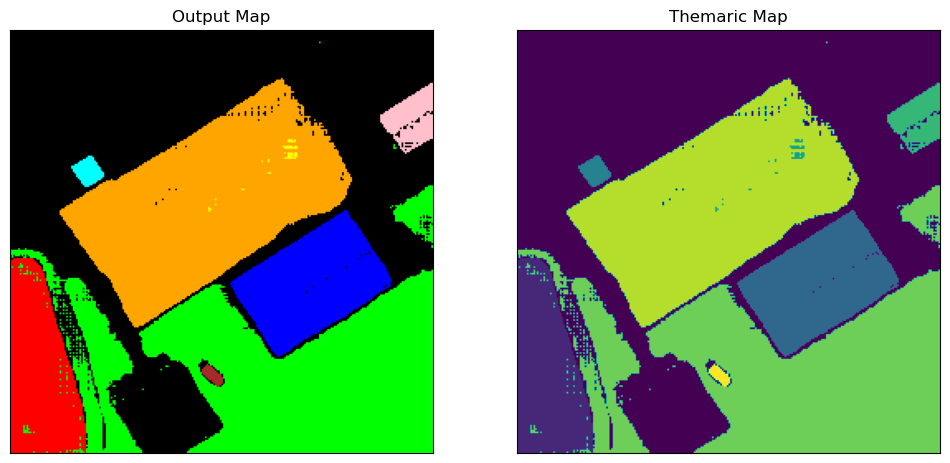

In [70]:
# n_class=classes.shape[0]

colors = ['red', 'green', 'blue', 'cyan', 'yellow', 'pink', 'lime', 'orange', 'brown']

rgb_form=[[255,0,0],#red
         [0, 128, 0],#Green
         [0, 0, 255],#Blue
         [0, 255, 255],#Cyan
         [255, 255, 0],#Yellow
         [255, 192, 203],# Pink
         [0, 255, 0],# Lime
         [255, 165, 0], #Orange
         [165, 42, 42], #Brown
         ]

rows,cols=masks_list[0].shape[1:]
RGB=np.zeros((rows,cols,3),dtype='uint8')
Thematic_map=np.zeros((rows,cols),dtype='float32')



for i in range(n_class):
    

    mask_number = input("Please enter the number corresponding to the best mask for class "+str(i+1)+": ")
    
    mask=masks_list[i]
    
    final_mask=mask[int(mask_number)-1]
    
    x,y=np.where(final_mask==1)
    
    RGB[x,y,0]=rgb_form[i][0]
    RGB[x,y,1]=rgb_form[i][1]
    
    RGB[x,y,2]=rgb_form[i][2]
    
    Thematic_map[x,y]=i+1
    
plt.figure(figsize=(12,8),dpi=100)

plt.subplot(1,2,1)
plt.imshow(RGB)
plt.xticks([])
plt.yticks([])
plt.title('Output Map')

plt.subplot(1,2,2)
plt.imshow(Thematic_map)
plt.xticks([])
plt.yticks([])
plt.title('Themaric Map')


plt.show()
    

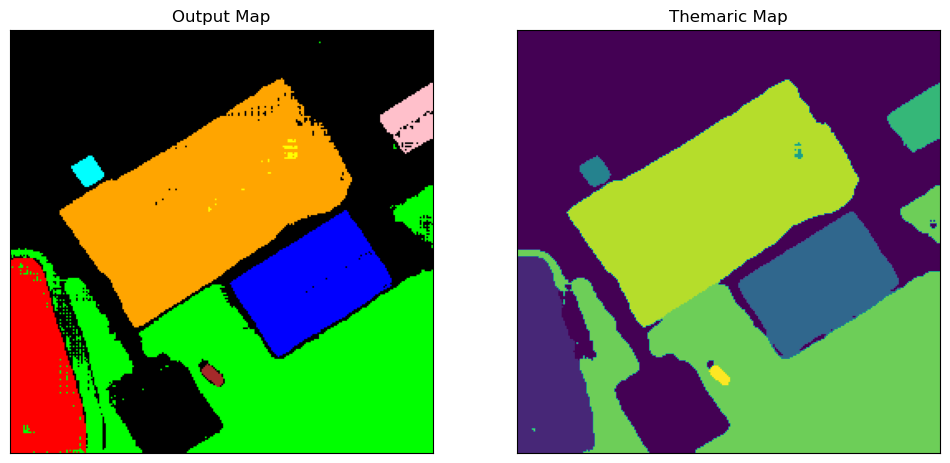

In [71]:
Thematic_map=ndimage.median_filter(Thematic_map, size=5)


plt.figure(figsize=(12,8),dpi=100)

plt.subplot(1,2,1)
plt.imshow(RGB)
plt.xticks([])
plt.yticks([])
plt.title('Output Map')

plt.subplot(1,2,2)
plt.imshow(Thematic_map)
plt.xticks([])
plt.yticks([])
plt.title('Themaric Map')


plt.show()

### Export Masks

In [ ]:
from osgeo import gdal

masks=Thematic_map

output_file = 'E:/Deep Course/Weeks/W12/Data/2_mask.tif'

# Create a new GeoTIFF file for the output data
driver = gdal.GetDriverByName("GTiff")
output_geotiff = driver.Create(output_file, masks.shape[1], masks.shape[0], 1, gdal.GDT_Float32)


# Set the projection and geotransform from one of the input files (e.g. geotiff_1)
filename='E:/Deep Course/Weeks/W12/Data/2.tif'
img = gdal.Open(filename)
output_geotiff.SetProjection(img.GetProjection())
output_geotiff.SetGeoTransform(img.GetGeoTransform())

# Write the output data to the file
output_geotiff.GetRasterBand(1).WriteArray(masks[:,:])

# Close the output GeoTIFF file
output_geotiff = None

In [ ]:
plt.imshow(masks)
plt.show()

In [ ]:
output_file